In [71]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import lognorm, halfcauchy
import pymc3 as pm
import theano
import theano.tensor as tt
import time
import datetime
from datetime import timedelta
import arviz as az
import seaborn as sns

In [72]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
recovered_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered=pd.read_csv(recovered_url, sep=',')
path_to_save = ''

In [73]:
data_end   = '3/15/20'
data_begin = '3/1/20'
num_days_to_predict = 28
N_germany = 83.7e6
cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", data_begin:data_end])[0]
date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", data_begin:data_end].columns[-1]
month, day, year = map(int,date_data_end.split('/'))
date_data_end = datetime.date(year+2000, month, day)
date_today = date_data_end + datetime.timedelta(days=1)
#print('Cases yesterday ({}): {} and day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = len(cases_obs)
np.random.seed(0)

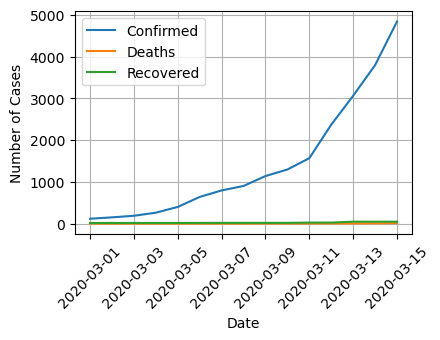

In [74]:
confirmed_cases_germany = confirmed_cases[confirmed_cases["Country/Region"] == "Germany"].iloc[:, 4:]
deaths_germany = deaths[deaths["Country/Region"] == "Germany"].iloc[:, 4:]
recovered_germany = recovered[recovered["Country/Region"] == "Germany"].iloc[:, 4:]
confirmed_cases_germany = confirmed_cases_germany.T
deaths_germany = deaths_germany.T
recovered_germany = recovered_germany.T
confirmed_cases_germany.columns = ['Confirmed']
deaths_germany.columns = ['Deaths']
recovered_germany.columns = ['Recovered']
confirmed_cases_germany.index = pd.to_datetime(confirmed_cases_germany.index)
deaths_germany.index = pd.to_datetime(deaths_germany.index)
recovered_germany.index = pd.to_datetime(recovered_germany.index)
confirmed_cases_germany = confirmed_cases_germany[data_begin:data_end]
deaths_germany = deaths_germany[data_begin:data_end]
recovered_germany = recovered_germany[data_begin:data_end]
plt.figure(figsize=(4.5, 3.5))
plt.plot(confirmed_cases_germany.index, confirmed_cases_germany['Confirmed'], label='Confirmed')
plt.plot(deaths_germany.index, deaths_germany['Deaths'], label='Deaths')
plt.plot(recovered_germany.index, recovered_germany['Recovered'], label='Recovered')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

In [76]:
def create_forecast(λ, μ, S_past, I_past, N_germany, num_days_to_predict, reduc_factor=0, days_offset=0, length_transient=7):
    time_arr = np.arange(num_days_to_predict)
    λ_correction = tt.clip((time_arr - delay - days_offset + 1) / length_transient, 0, 1)
    λ_t = λ * (1 - λ_correction * reduc_factor)
    S_begin = S_past[-1]
    I_begin = I_past[-1]
    S_future, I_future, new_I_future = SIR_model(λ=λ_t, μ=μ, S_begin=S_begin, I_begin=I_begin, N=N_germany)
    return S_future, I_future, new_I_future

In [77]:
with pm.Model() as model:
    I_begin_prior = lognorm(s=0.1, scale=np.exp(np.log(cases_obs[0])))
    λ_prior = lognorm(s=0.1, scale=np.exp(np.log(0.4)))
    μ_prior = lognorm(s=0.2, scale=np.exp(np.log(1/8)))
    σ_prior = halfcauchy(scale=3)
    delay_prior = lognorm(s=0.1, scale=np.exp(np.log(8)))
    
    I_begin = pm.Lognormal("I_begin", mu=np.log(cases_obs[0]), sigma=0.1)
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.1)
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)
    σ = pm.HalfCauchy("σ", beta=3)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.1)

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, S_begin=S_begin, I_begin=I_begin, N=N_germany)
    new_infections_obs = np.diff(cases_obs)
    
    pm.StudentT("obs", nu=4, mu=new_I_past, sigma=new_I_past ** 0.5 * σ, observed=new_infections_obs)
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)

    # Forecasts
    S_no_change, I_no_change, new_I_no_change = create_forecast(λ, μ, S_past, I_past, N_germany, num_days_to_predict)
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)
    
    S_soc_dist, I_soc_dist, new_I_soc_dist = create_forecast(λ, μ, S_past, I_past, N_germany, num_days_to_predict, reduc_factor=0.5)
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)
    
    S_isol, I_isol, new_I_isol = create_forecast(λ, μ, S_past, I_past, N_germany, num_days_to_predict, reduc_factor=0.9)
    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)
    pm.Deterministic('new_I_isol', new_I_isol)
    
    S_isol_later, I_isol_later, new_I_isol_later = create_forecast(λ, μ, S_past, I_past, N_germany, num_days_to_predict, reduc_factor=0.9, days_offset=7)
    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)
    pm.Deterministic('new_I_isol_later', new_I_isol_later)
    
    S_isol_earlyier, I_isol_earlyier, new_I_isol_earlyier = create_forecast(λ, μ, S_past, I_past, N_germany, num_days_to_predict, reduc_factor=0.9, days_offset=-7)
    pm.Deterministic('S_isol_earlyier', S_isol_earlyier)
    pm.Deterministic('I_isol_earlyier', I_isol_earlyier)
    pm.Deterministic('new_I_isol_earlyier', new_I_isol_earlyier)


    time_beg = time.time()
    trace = pm.sample(draws=1000, tune=1500, chains=4)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delay, σ, μ, λ, I_begin]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 73 seconds.
The acceptance probability does not match the target. It is 0.697045465912794, but should be close to 0.8. Try to increase the number of tuning steps.


Model run in 93.72 s


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


            mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
λ          0.394   0.019   0.358    0.428      0.001    0.000    1069.0   
μ          0.125   0.022   0.084    0.164      0.001    0.000    1186.0   
I_begin  115.771  10.729  96.563  136.157      0.280    0.198    1463.0   
σ          4.994   1.344   2.507    7.374      0.035    0.025    1056.0   
delay      8.046   0.797   6.612    9.493      0.018    0.013    1950.0   

         ess_tail  r_hat  
λ          1383.0    1.0  
μ          1050.0    1.0  
I_begin    1412.0    1.0  
σ           441.0    1.0  
delay      1317.0    1.0  


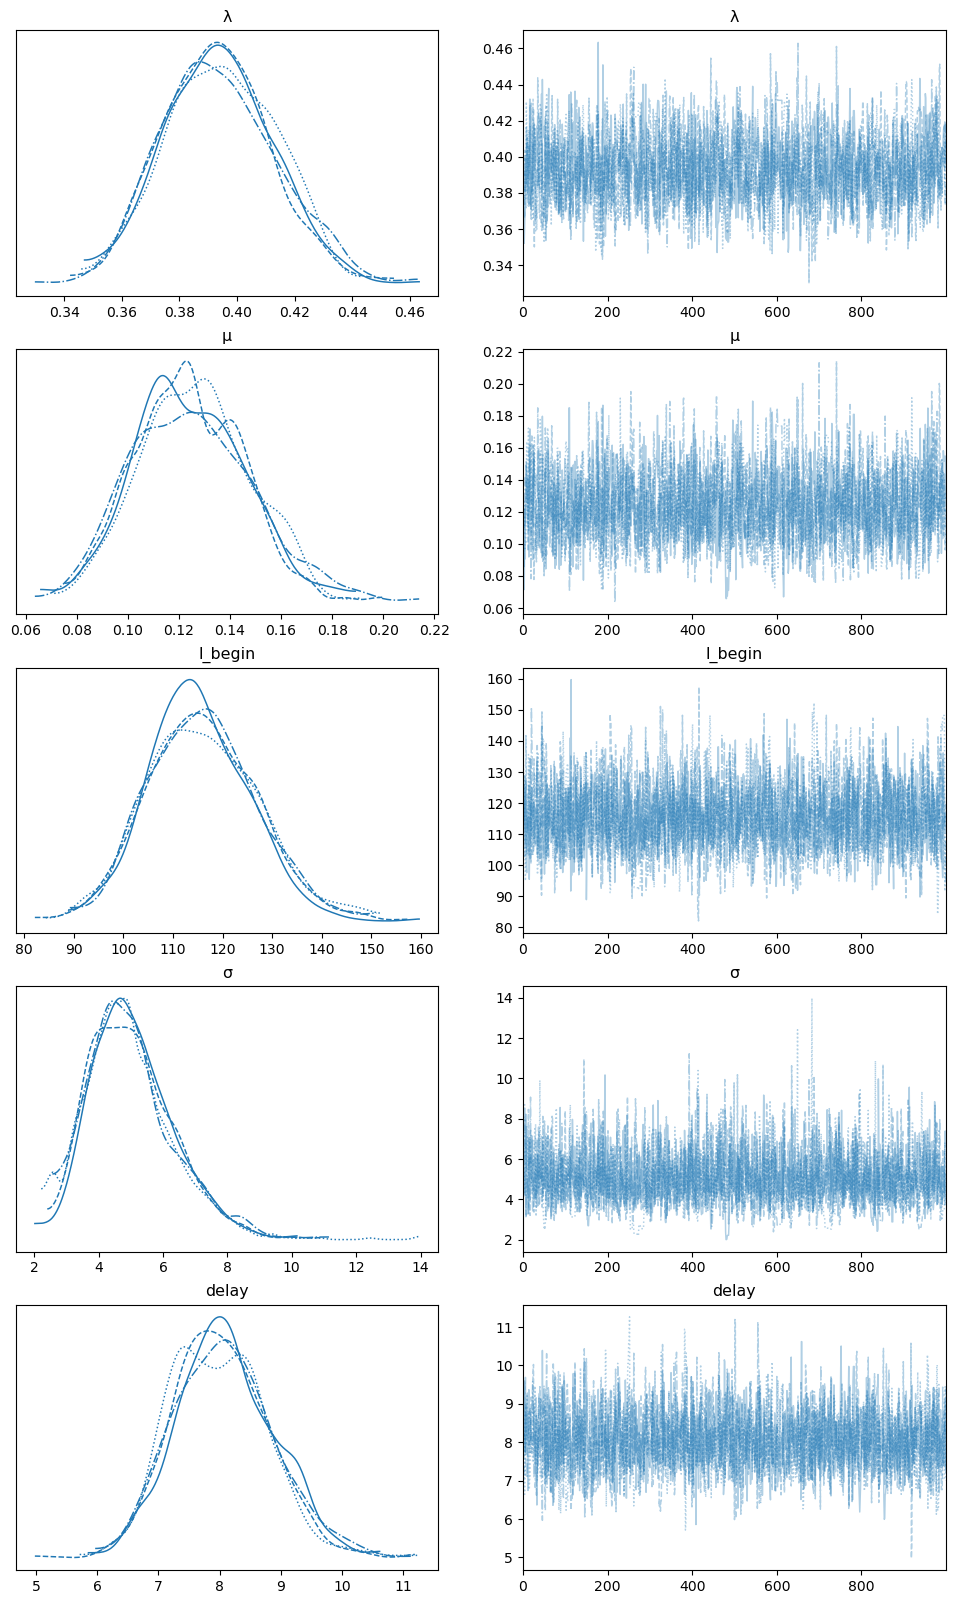

In [78]:
az.plot_trace(trace,var_names=["λ", "μ", "I_begin","σ","delay"],figsize=(12, 20))
df = az.summary(trace, var_names=["λ", "μ", "I_begin", "σ", "delay"])
print(df)
plt.show()

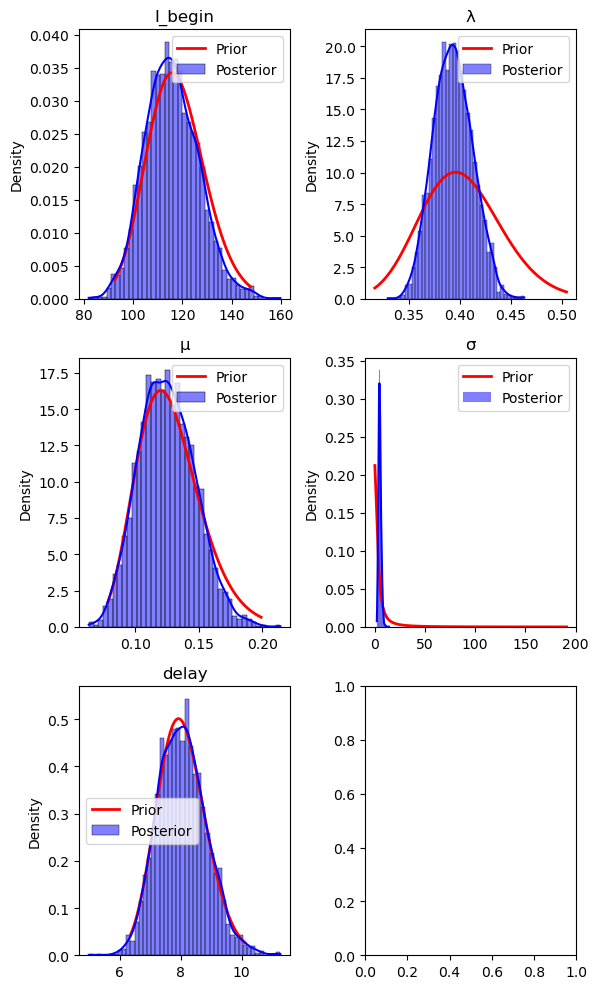

In [79]:
def plot_prior_posterior(prior, posterior, label, ax):
    x = np.linspace(prior.ppf(0.01), prior.ppf(0.99), 100)
    y = prior.pdf(x)
    ax.plot(x, y, 'r-', lw=2, label='Prior')
    sns.histplot(posterior, kde=True, ax=ax, label='Posterior', color='blue', stat="density")
    ax.legend()
    ax.set_title(label)
fig, axs = plt.subplots(3, 2, figsize=(6, 10))
plot_prior_posterior(I_begin_prior, trace['I_begin'], 'I_begin', axs[0, 0])
plot_prior_posterior(λ_prior, trace['λ'], 'λ', axs[0, 1])
plot_prior_posterior(μ_prior, trace['μ'], 'μ', axs[1, 0])
plot_prior_posterior(σ_prior, trace['σ'], 'σ', axs[1, 1])
plot_prior_posterior(delay_prior, trace['delay'], 'delay', axs[2, 0])
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Width $\\sigma$ of Student T')

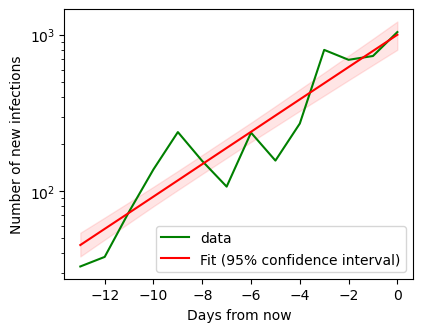

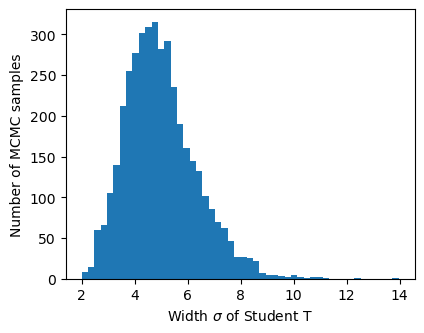

In [80]:
time = np.arange(-len(cases_obs)+2, 1,step=1)

plt.figure(figsize=(4.5,3.5))
plt.plot(time, np.diff(cases_obs), color='green',label='data')
percentiles = np.percentile(trace.new_I_past, q=2.5, axis=0), np.percentile(trace.new_I_past, q=97.5, axis=0)
plt.plot(time, np.median(trace.new_I_past, axis=0),color='red', label='Fit (95% confidence interval)')
plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.1, color='red')
plt.yscale('log')
plt.ylabel('Number of new infections')
plt.xlabel('Days from now')
plt.legend()

plt.figure(figsize=(4.5,3.5))
plt.hist(trace.σ, bins=50)
plt.ylabel('Number of MCMC samples')
plt.xlabel('Width $\sigma$ of Student T')

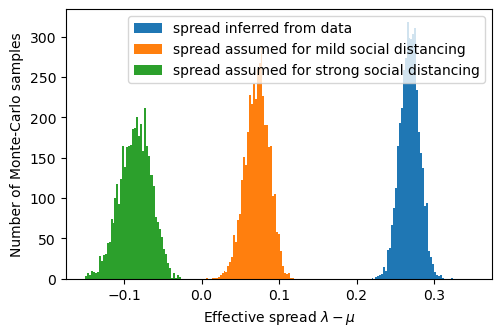

In [95]:
def plot_distribution(trace, reduc_factor_mild, reduc_factor_strong):
    plt.figure(figsize=(5.5, 3.5))
    bins = np.linspace(-0.15, 0.35, 200)
    plt.hist(trace.λ - trace.μ, bins=bins, label='spread inferred from data')
    plt.hist(np.maximum(trace.λ * (1 - reduc_factor_mild), 0) - trace.μ, bins=bins, label='spread assumed for mild social distancing')
    plt.hist(np.maximum(trace.λ * (1 - reduc_factor_strong), 0) - trace.μ, bins=bins, label='spread assumed for strong social distancing')
    plt.xlabel('Effective spread $\lambda - \mu$')
    plt.ylabel('Number of Monte-Carlo samples')
    plt.legend()
    plt.show()

plot_distribution(trace, reduc_factor_mild=0.5, reduc_factor_strong=0.9)

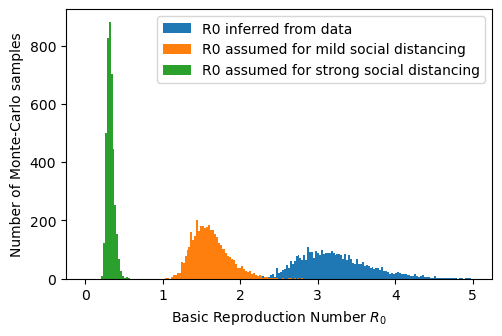

In [96]:
def plot_R0(trace, reduc_factor_mild, reduc_factor_strong):
    R0_inferred = trace.λ / trace.μ
    R0_mild_dist = np.maximum(trace.λ * (1 - reduc_factor_mild) / trace.μ, 0)
    R0_strong_dist = np.maximum(trace.λ * (1 - reduc_factor_strong) / trace.μ, 0)
    plt.figure(figsize=(5.5, 3.5))
    bins = np.linspace(0, 5, 200)
    plt.hist(R0_inferred, bins=bins, label='R0 inferred from data')
    plt.hist(R0_mild_dist, bins=bins, label='R0 assumed for mild social distancing')
    plt.hist(R0_strong_dist, bins=bins, label='R0 assumed for strong social distancing')
    plt.xlabel('Basic Reproduction Number $R_0$')
    plt.ylabel('Number of Monte-Carlo samples')
    plt.legend()
    plt.show()

plot_R0(trace, reduc_factor_mild=0.5, reduc_factor_strong=0.9)

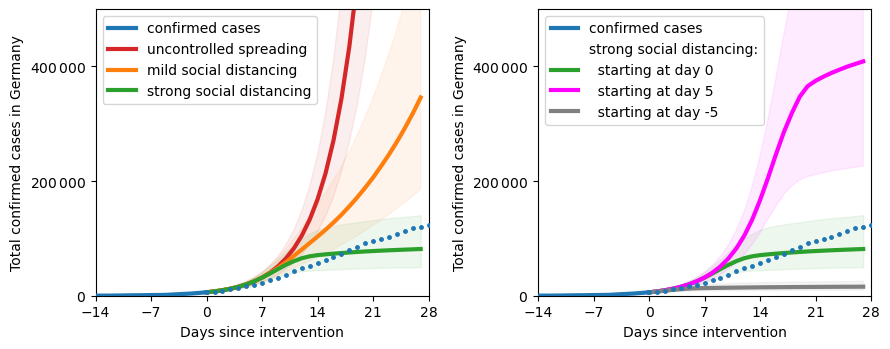

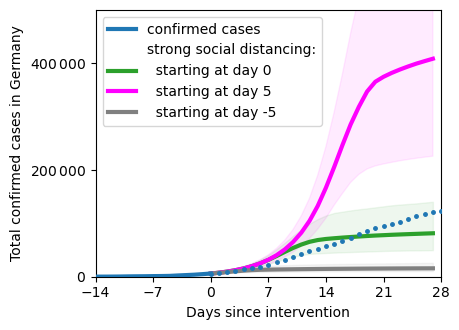

In [101]:
legends_lang = {
    "english": [
        "confirmed cases",
        [
            "uncontrolled spreading",
            "mild social distancing",
            "strong social distancing",
        ],
        "Days since intervention",
        "Total confirmed cases in Germany",
        "Start of intervention",
        'confirmed cases',['strong social distancing:',
                           '  starting at day 0', 
                           '  starting at day 5',
                           "  starting at day -5"],
        'Days since intervention',
        'Total confirmed cases in Germany',
        'Start of intervention',
    ],
}
obs_cases_labels = ['new_I_no_change', 'new_I_soc_dist', 'new_I_isol', 'new_I_isol_later', 'new_I_isol_earlyier']
date_today_formatted = '{}/{}/{}'.format(date_today.month, date_today.day, str(date_today.year)[2:4])
cases_obs_to_plot = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', '2/26/20':date_today_formatted])[0]
cases_obs_to_plot_future = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', date_today_formatted:])[0]

def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
        np.sum(trace.new_I_past, axis=1)[:, None] + trace.I_begin[:, None]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)

for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[9, 3.6])
    colors = ["tab:red", "tab:orange", "tab:green", "gray"]
    dict_obsc_cases = return_obs_cases_future(trace)
    ax = axes[0]
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3, color='tab:blue', zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', zorder=5)
    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
        median = np.median(cases, axis=-1)
        percentiles = (np.percentile(cases, q=2.5, axis=-1),np.percentile(cases, q=97.5, axis=-1),)
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)
    ax.set_xlim(-14, 28)
    ax.set_ylim(0, 500_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21, 28])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))

    f_alone, ax_alone = plt.subplots(figsize=(4.7,3.4))
    for i, (ax, f) in enumerate(((axes[1],fig), (ax_alone, f_alone))):
        colors = ["tab:green", "fuchsia", 'gray']
        time = np.arange(-len(cases_obs_to_plot)+1, 1)
        ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', zorder=5)
        time = np.arange(0, len(cases_obs_to_plot_future))
        ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', zorder=5)
        time = np.arange(-len(cases_obs) + 1, 1)

        dict_obsc_cases = return_obs_cases_future(trace)
        ax.plot([], [], alpha=0, label=legends_list[6][0])
        for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6][1:]):
            time = np.arange(num_days_to_predict)
            cases = dict_obsc_cases[label]
            median = np.median(cases, axis=-1)
            percentiles = (np.percentile(cases, q=2.5, axis=-1),np.percentile(cases, q=97.5, axis=-1),)
            ax.plot(time, median, color, linewidth=3, label=legend)
            ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

        ax.set_xlim(-14, 28)
        ax.set_ylim(0, 500_000)
        ax.set_yscale("linear")
        ax.set_xlabel(legends_list[7])
        ax.set_ylabel(legends_list[8])
        ax.locator_params(axis="y", nbins=4)
        ax.legend(loc="upper left")
        ax.set_xticks([-14, -7, 0, 7, 14, 21, 28])
        func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
        f.tight_layout()

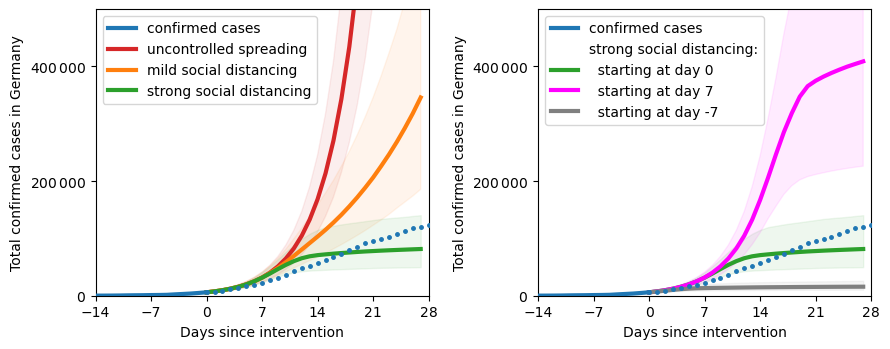

In [114]:
legends_lang = {
    "english": [
        "confirmed cases",
        [
            "uncontrolled spreading",
            "mild social distancing",
            "strong social distancing",
        ],
        "Days since intervention",
        "Total confirmed cases in Germany",
        "Start of intervention",
        'confirmed cases',['strong social distancing:',
                           '  starting at day 0', 
                           '  starting at day 7',
                           "  starting at day -7"],
        'Days since intervention',
        'Total confirmed cases in Germany',
        'Start of intervention',
    ],
}

obs_cases_labels = ['new_I_no_change', 'new_I_soc_dist', 'new_I_isol', 'new_I_isol_later', 'new_I_isol_earlyier']
date_today_formatted = '{}/{}/{}'.format(date_today.month, date_today.day, str(date_today.year)[2:4])
cases_obs_to_plot = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', '2/26/20':date_today_formatted])[0]
cases_obs_to_plot_future = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', date_today_formatted:])[0]

def return_obs_cases_future(trace):
    obs_cases_future = dict()
    for label in obs_cases_labels:
        obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
            np.sum(trace.new_I_past, axis=1)[:, None] + trace.I_begin[:, None]
        obs_cases_future[label] = obs_cases_future[label].T
    return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)

for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[9, 3.6])
    colors = ["tab:red", "tab:orange", "tab:green", "gray"]
    dict_obsc_cases = return_obs_cases_future(trace)
    ax = axes[0]
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3, color='tab:blue', zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', zorder=5)
    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
        median = np.median(cases, axis=-1)
        percentiles = (np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1))
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)
    ax.set_xlim(-14, 28)
    ax.set_ylim(0, 500_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21, 28])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))

    ax = axes[1]
    colors = ["tab:green", "fuchsia", 'gray']
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)
    dict_obsc_cases = return_obs_cases_future(trace)
    ax.plot([], [], alpha=0, label=legends_list[6][0])
    for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6][1:]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        median = np.median(cases, axis=-1)
        percentiles = (np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1))
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 28)
    ax.set_ylim(0, 500_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21, 28])
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    fig.tight_layout()

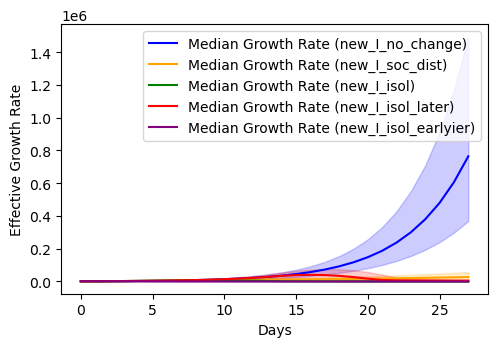

In [107]:
def plot_effective_growth_rate_p(trace, num_days_to_predict, labels, colors):
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    for label, color in zip(labels, colors):
        if 'no_change' in label:
            S_future = trace['S_no_change']
        elif 'soc_dist' in label:
            S_future = trace['S_soc_dist']
        elif 'isol' in label:
            if 'later' in label:
                S_future = trace['S_isol_later']
            elif 'earlier' in label:
                S_future = trace['S_isol_earlyier']
            else:
                S_future = trace['S_isol']
        λ_future = trace[label] / S_future * N_germany
        μ_future = trace['μ'][:, None]
        effective_growth_rate_future = λ_future - μ_future
        median_growth_rate_future = np.median(effective_growth_rate_future, axis=0)
        percentiles_growth_rate_future = (
            np.percentile(effective_growth_rate_future, q=2.5, axis=0),
            np.percentile(effective_growth_rate_future, q=97.5, axis=0),
        )
        ax.plot(np.arange(num_days_to_predict), median_growth_rate_future, label=f"Median Growth Rate ({label})", color=color)
        ax.fill_between(np.arange(num_days_to_predict), percentiles_growth_rate_future[0], percentiles_growth_rate_future[1], alpha=0.2, color=color)
    ax.set_xlabel("Days")
    ax.set_ylabel("Effective Growth Rate")
    ax.legend()
    plt.show()
labels = ['new_I_no_change', 'new_I_soc_dist', 'new_I_isol', 'new_I_isol_later', 'new_I_isol_earlyier']
colors = ['blue', 'orange', 'green', 'red', 'purple']
plot_effective_growth_rate_p(trace, num_days_to_predict, labels, colors)

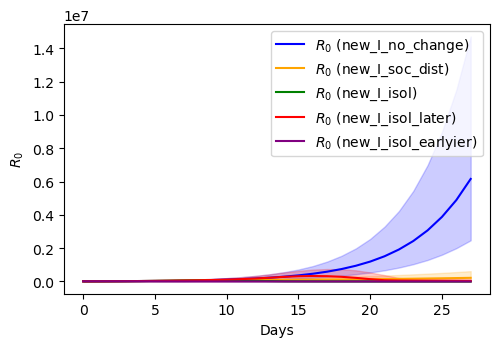

In [93]:
def plot_R0_p(trace, num_days_to_predict, labels, colors):
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    for label, color in zip(labels, colors):
        if 'no_change' in label:
            S_future = trace['S_no_change']
        elif 'soc_dist' in label:
            S_future = trace['S_soc_dist']
        elif 'isol' in label:
            if 'later' in label:
                S_future = trace['S_isol_later']
            elif 'earlier' in label:
                S_future = trace['S_isol_earlyier']
            else:
                S_future = trace['S_isol']
        λ_future = trace[label] / S_future * N_germany
        μ_future = trace['μ'][:, None]
        R0_future = λ_future / μ_future
        median_R0_future = np.median(R0_future, axis=0)
        percentiles_R0_future = (np.percentile(R0_future, q=2.5, axis=0),np.percentile(R0_future, q=97.5, axis=0))
        ax.plot(np.arange(num_days_to_predict), median_R0_future, label=f"$R_0$ ({label})", color=color)
        ax.fill_between(np.arange(num_days_to_predict), percentiles_R0_future[0], percentiles_R0_future[1], alpha=0.2, color=color)
    ax.set_xlabel("Days")
    ax.set_ylabel("$R_0$")
    ax.legend()
    plt.show()
labels = ['new_I_no_change', 'new_I_soc_dist', 'new_I_isol', 'new_I_isol_later', 'new_I_isol_earlyier']
colors = ['blue', 'orange', 'green', 'red', 'purple']
plot_R0_p(trace, num_days_to_predict, labels, colors)